In [1]:
#!pip install datasets
#!pip install transformers
#!pip install --upgrade torchvision
#!pip install tensorboard

In [2]:
import numpy as np
from datasets import load_dataset
import json
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
from torch.utils.data import DataLoader
import torch
from transformers import ViTForImageClassification
from transformers import file_utils
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import time
from transformers import EarlyStoppingCallback, IntervalStrategy

/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
train_ds = load_dataset("imagefolder", data_dir="UrbanSound8K/noisy_mel", split="train")

Resolving data files:   0%|          | 0/8735 [00:00<?, ?it/s]

Using custom data configuration default-e3d04b364fb1fe52
Found cached dataset imagefolder (/home/suvivars/.cache/huggingface/datasets/imagefolder/default-e3d04b364fb1fe52/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [3]:
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


In [4]:
print(len(train_ds),len(test_ds),len(val_ds))

5500 2620 612


In [5]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [6]:
with open('UrbanSound8K/noisy_mel/label2id.json') as f:
    label2id = json.load(f)

with open('UrbanSound8K/noisy_mel/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [7]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [8]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

In [9]:
_train_transforms = Compose(
        [
            RandomResizedCrop(tuple(feature_extractor.size.values())),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(tuple(feature_extractor.size.values())),
            CenterCrop(tuple(feature_extractor.size.values())),
            ToTensor(),
            normalize,
        ]
    )

In [10]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [11]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [93]:
train_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=334x217 at 0x7F587D9EED30>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=334x217 at 0x7F587DA135C0>],
 'classID': [6, 4],
 'class': ['gun_shot', 'drilling'],
 'pixel_values': [tensor([[[-0.2784, -0.2784, -0.2157,  ..., -0.1765, -0.1922, -0.1922],
           [-0.2784, -0.2784, -0.2157,  ..., -0.1765, -0.1922, -0.1922],
           [-0.2863, -0.2863, -0.2549,  ..., -0.2078, -0.2157, -0.2157],
           ...,
           [-0.1608, -0.1608, -0.2078,  ..., -0.2000, -0.1294, -0.1294],
           [-0.3255, -0.3255, -0.3020,  ..., -0.2941, -0.2471, -0.2471],
           [-0.3255, -0.3255, -0.3020,  ..., -0.2941, -0.2471, -0.2471]],
  
          [[-0.8275, -0.8275, -0.8039,  ..., -0.7804, -0.7882, -0.7882],
           [-0.8275, -0.8275, -0.8039,  ..., -0.7804, -0.7882, -0.7882],
           [-0.8275, -0.8275, -0.8118,  ..., -0.7961, -0.7961, -0.7961],
           ...,
           [-0.7804, -0.7804, -0.7961,  ..., -0.7882, -0.

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)


In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [15]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
metric_name = "accuracy"

args = TrainingArguments(
    f"train-noisy-UrbanSounds8k",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False
)



In [18]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)


In [20]:
#Using GPU
start_time = time.time()
trainer.train()
print('Total Time Taken (in sec):',time.time()-start_time)

/home/suvivars/.conda/envs/271/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5500
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 27500
  Number of trainable parameters = 85806346


Epoch,Training Loss,Validation Loss,Accuracy
1,1.619500,1.129812,0.668301
2,1.096600,0.902448,0.725490
3,0.904300,0.693091,0.807190
4,0.806000,0.566548,0.844771
5,0.730000,0.558857,0.838235
6,0.656500,0.504468,0.856209
7,0.630100,0.465418,0.866013
8,0.596800,0.474295,0.861111
9,0.566600,0.444372,0.869281
10,0.518400,0.437743,0.869281


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-550
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-550/config.json
Model weights saved in train-noisy-UrbanSounds8k/checkpoint-550/pytorch_model.bin
Image processor saved in train-noisy-UrbanSounds8k/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-1100
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-1100/config.json
Model weights saved in train-noisy-UrbanSounds8k/checkpoint-1100/pytorch_model.bin
Image processor saved in train-noisy-UrbanSounds8k/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-1650
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-1650/config.json
Model wei

***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-12100
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-12100/config.json
Model weights saved in train-noisy-UrbanSounds8k/checkpoint-12100/pytorch_model.bin
Image processor saved in train-noisy-UrbanSounds8k/checkpoint-12100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-12650
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-12650/config.json
Model weights saved in train-noisy-UrbanSounds8k/checkpoint-12650/pytorch_model.bin
Image processor saved in train-noisy-UrbanSounds8k/checkpoint-12650/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to train-noisy-UrbanSounds8k/checkpoint-13200
Configuration saved in train-noisy-UrbanSounds8k/checkpoint-13200/config.

Total Time Taken (in sec): 5164.398083925247


In [21]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [22]:
print(outputs.metrics)

{'test_loss': 0.2641521394252777, 'test_accuracy': 0.9267175572519084, 'test_runtime': 23.3625, 'test_samples_per_second': 112.145, 'test_steps_per_second': 28.036}


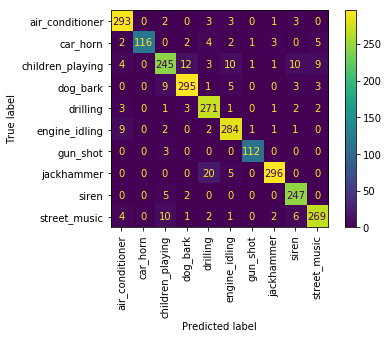

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)


In [27]:
model.save_pretrained("models/Noisy-UrbanSounds8k-EarlyStopping")

Configuration saved in models/Noisy-UrbanSounds8k-EarlyStopping/config.json
Model weights saved in models/Noisy-UrbanSounds8k-EarlyStopping/pytorch_model.bin


In [3]:
logs='Epoch	Training Loss	Validation Loss	Accuracy\t\
1	1.619500	1.129812	0.668301\t\
2	1.096600	0.902448	0.725490\t\
3	0.904300	0.693091	0.807190\t\
4	0.806000	0.566548	0.844771\t\
5	0.730000	0.558857	0.838235\t\
6	0.656500	0.504468	0.856209\t\
7	0.630100	0.465418	0.866013\t\
8	0.596800	0.474295	0.861111\t\
9	0.566600	0.444372	0.869281\t\
10	0.518400	0.437743	0.869281\t\
11	0.482200	0.414973	0.882353\t\
12	0.470200	0.418241	0.874183\t\
13	0.455200	0.403654	0.877451\t\
14	0.457200	0.381544	0.880719\t\
15	0.413400	0.366942	0.897059\t\
16	0.430500	0.371515	0.895425\t\
17	0.375100	0.344439	0.908497\t\
18	0.399400	0.359115	0.893791\t\
19	0.386900	0.331478	0.893791\t\
20	0.397500	0.366107	0.906863\t\
21	0.349000	0.326423	0.916667\t\
22	0.345100	0.304430	0.918301\t\
23	0.334800	0.378935	0.901961\t\
24	0.342900	0.365086	0.903595\t\
25	0.327400	0.340283	0.905229\t\
26	0.328700	0.312215	0.921569\t\
27	0.312200	0.320261	0.918301\t\
28	0.325100	0.318343	0.910131\t\
29	0.304900	0.324152	0.913399\t\
30	0.294100	0.327591	0.916667\t\
31	0.282900	0.310520	0.918301'

In [4]:
epoch=logs.split('\t')[::4][1:]
epoch=list(map(int, epoch))
training_loss=logs.split('\t')[1::4][1:]
training_loss=list(map(float, training_loss))
validation_loss=logs.split('\t')[2::4][1:]
validation_loss=list(map(float, validation_loss))
accuracy=logs.split('\t')[3::4][1:]
accuracy=list(map(float, accuracy))

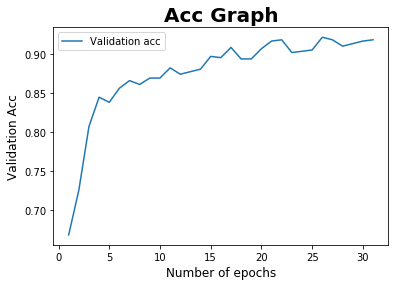

In [7]:
#Acc graph
plt.plot(epoch,accuracy,label='Validation acc')
plt.xlabel('Number of epochs',fontsize=12)
plt.ylabel('Validation Acc',fontsize=12)
plt.legend(loc="upper left")
plt.title('Acc Graph',fontsize=20,fontweight='bold')
#plt.show()
plt.savefig('Noisy-Acc.jpg')

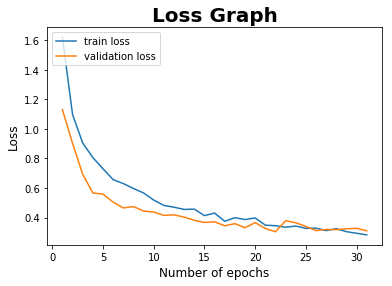

In [9]:
#Loss graph
plt.plot(epoch,training_loss,label='train loss')
plt.plot(epoch,validation_loss,label='validation loss')
plt.xlabel('Number of epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend(loc="upper left")
plt.title('Loss Graph',fontsize=20,fontweight='bold')
#plt.show()
plt.savefig('Noisy-Loss.jpg')